In [1]:
%run stdPackages.ipynb
os.chdir(d['py'])
import US_EulerModel_main, US_EulerModel_c, US_EulerModel_policy
os.chdir(d['curr'])

## US FH:

Define data and parameters:

In [2]:
dates_log = pd.Index([1950, 1980, 2010, 2040, 2070, 2100], name = 't')
ν_log = np.array([1.504840069, 1.394563144, 1.178137696, 1.055068673, 1.018706685, 1.018706685])
T_log = len(ν_log)
T = T_log+5
dates = dates_log.union(pd.Index([dates_log[-1]+30*i for i in range(1,T-T_log+1)]))
ν = np.hstack([ν_log, np.full(T-T_log, ν_log[-1])])
A = np.ones(T) # normalize exog. productivity at 1 
t0date = 2010 # calibration date
t0 = dates.get_loc(t0date) # index for year of calibration 


# "Simple" calibration:
α = .281 # capital income share

# Household types:
size = np.array([311802, 97786, 129258, 3589])
γi = size/size.sum()
ni = len(γi)
hours = np.array([2068.9, 2316.6, 2429.3, 2679.6]) # hours
wagerates = np.array([15.10, 27.43, 51.62, 197.2]) # wages
income = hours*wagerates
zxi = hours/hours.mean()
zηi = income/income.mean()

μi = np.array([0.494, 0.690, 0.750, 0.750]) # voter turnout


### NOT UPDATED YET
pi = np.array([0.606, 0.7486, 0.821, 0.821]) # mortality rates
RRgroups = (0,1)
# pi = np.array([0.385, 0.55, 0.652, 0.74]) # mortality rates


# other targets:
τ0 = .158 # target labor tax rate
RR = 39.4/50.1 # replacement rate
universalShare = 3.4/15.8 # share of ss going to universal
R0 = 2.443 


# Initial/baseline values:
ξ0 = .5
ρ0 = 1 # log value
ω0 = 1.5
# βj = np.ones(ni+1)

Package them in kwargs:

In [3]:
kwargs = {'α': α, 'A': A, 'ν': ν, 'γi': γi, 'zxi': zxi, 'zηi': zηi, 'pi': pi, 'μi': μi, 'τ0': τ0, 'RR0': RR, 'UShare0': universalShare, 'R0': R0, 'ξ': ξ0, 'ρ': ρ0, 'ω': ω0}

Initialize model:

In [4]:
m = US_EulerModel_main.Model(ni = ni, T = T, ngrid = 50, RRgroups = RRgroups,  **kwargs)

## Calibration:

It is straightforward to calibrate the model to target interest rates and tax levels. It is, however, more difficult to target the choice of $\kappa$. Here, we use a golden-section like search procedure:
1. First, we loop through a grid of $\xi$ values and calibrate to the other targets.
2. Based on the difference between target and choice of $\kappa_{t_0}(\xi)$, we identify the two nodes on the grid of $\xi$ where the sign changes (from above to below target level). Between these nodes we add a linear grid of length $n$ (default is zero) *and* add the linearly interpolated level of $\xi$ that would result in the target $\kappa$. We then solve again on this grid.
3. The procedure in step 2 is carried out until the distance from choice and target of $\kappa_{t_0}$ is below some specified tolerance.

In [5]:
ξgrid = np.round(np.linspace(ξ0, .1, 51), 3) # create initial grid to solve over

*Return grid of solutions to see how the model changes with $\xi$:*

In [6]:
# sols = m.USCal_OnGrid(ξgrid, t0, full_output = True); # the full_output means that 'sol' 

*Golden section search for calibration parameters:*

In [7]:
cal = m.USCal_GoldenSection(ξgrid, t0, n = 2, tol = 1e-5, iterMax = 5) 

Use calibration parameters to get baseline run:

In [8]:
m.db['ξ'] = cal['ξ']
m.db['ω'] = cal['ω']
m.db['βi'] = m.US_β(cal['β'])
sol = m.ESC_log_FH()

## Plot baseline:

Plot $\tau, \kappa, h, s$ over time (all 1d objects defined over time), so simple to concatenate):

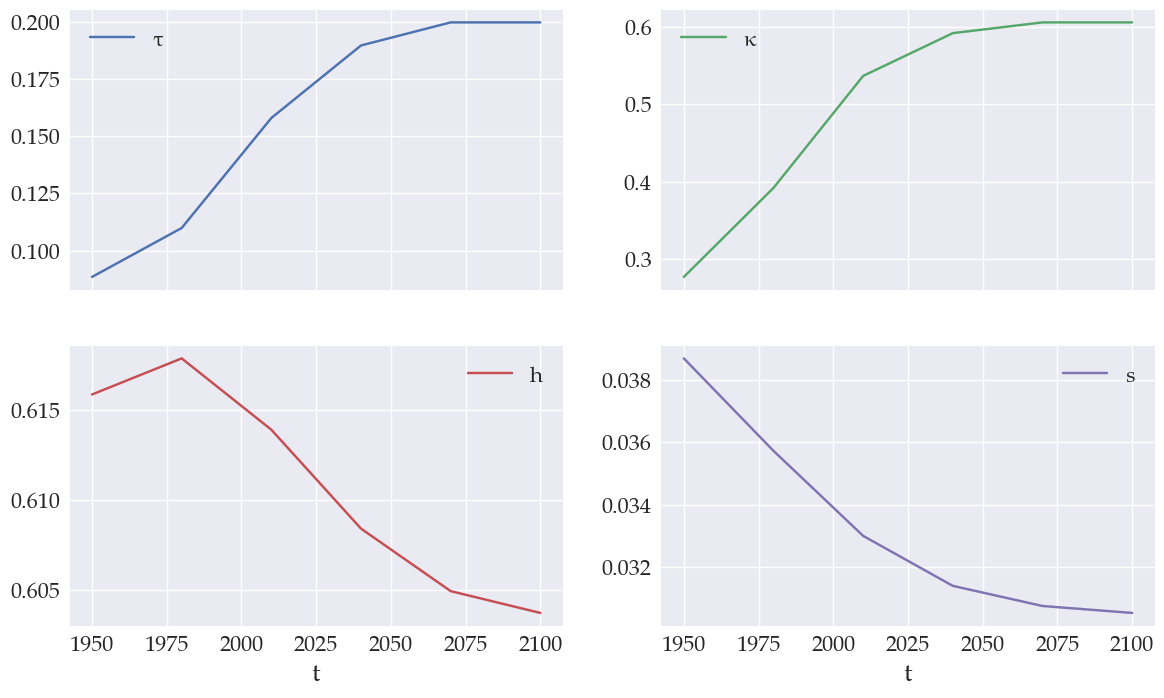

In [9]:
mult_graphs()
df = pd.concat([sol[k].rename(k) for k in ('τ','κ','h','s')], axis = 1).set_axis(dates, axis = 0)
df.loc[dates_log].plot(subplots=True, figsize=(14,8), layout = (2,2));